In [1]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

In [2]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 2s 0us/step
(60000, 28, 28, 1)


In [3]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [4]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

In [5]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [6]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [7]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [8]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
discriminator = define_discriminator()

C:\Users\rsshi\anaconda3\envs\dlc\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model
generator = define_generator(100)

C:\Users\rsshi\anaconda3\envs\dlc\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [10]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
gan_model = define_gan(generator, discriminator)

In [11]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

2/2 [==============================] - 0s 10ms/step
>1, dr[0.172,1.000], df[0.705,0.000], g[0.685,1.000]
2/2 [==============================] - 0s 7ms/step
>2, dr[0.012,1.000], df[0.713,0.000], g[0.678,1.000]
2/2 [==============================] - 0s 6ms/step
>3, dr[0.005,1.000], df[0.721,0.000], g[0.672,1.000]
2/2 [==============================] - 0s 15ms/step
>4, dr[0.005,1.000], df[0.731,0.000], g[0.666,1.000]
2/2 [==============================] - 0s 9ms/step
>5, dr[0.004,1.000], df[0.742,0.000], g[0.661,1.000]
2/2 [==============================] - 0s 9ms/step
>6, dr[0.004,1.000], df[0.749,0.000], g[0.659,1.000]
2/2 [==============================] - 0s 10ms/step
>7, dr[0.005,1.000], df[0.748,0.000], g[0.669,0.984]
2/2 [==============================] - 0s 9ms/step
>8, dr[0.006,1.000], df[0.744,0.000], g[0.682,0.750]
2/2 [==============================] - 0s 9ms/step
>9, dr[0.007,1.000], df[0.724,0.031], g[0.707,0.219]
2/2 [==============================] - 0s 10ms/step
>10, dr[0

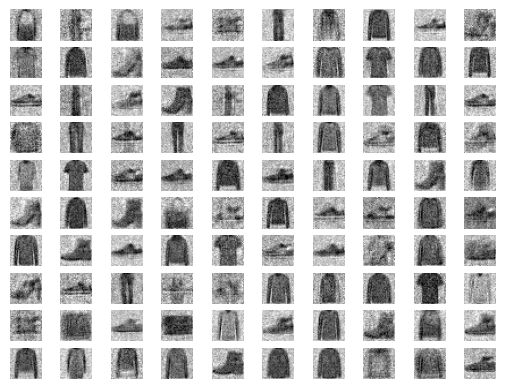

In [12]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

In [18]:
model = load_model('model_18740.h5')
latent_dim = 100
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)

4/4 [==============================] - 1s 86ms/step


ValueError: Number of rows must be a positive integer, not 10.0

<Figure size 640x480 with 0 Axes>